## Accelegrad vs UnixGrad Analysis 

#### Import Libraries 

In [52]:
import os
import sys
import numpy as np
from scipy import sparse 
import pandas as pd
from random import randrange
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from tqdm.notebook import tqdm


module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
print("Main Directory: ", module_path)


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Main Directory:  /Users/francescomandru/Desktop/Projects/Optimization


In [211]:
def load_data( path ):

    # import
    data = pd.read_csv( path, delimiter=',')
    data = data.drop('id', axis=1)
    data = data.drop('Unnamed: 32', axis=1)
    data['diagnosis'] = np.array(data['diagnosis'].map(lambda x: 1 if x=='M' else -1))
    
    features = np.array(data)[:,1:]
    
    # normalization
    scaler = preprocessing.StandardScaler().fit(features)
    features = scaler.transform(features)
    
    b = np.ones(len(features)).reshape(-1,1)
    features = np.hstack((features,b))
    
    # labels
    labels = np.array(data)[:,0]
    labels[labels==0] = -1
    labels = labels.reshape((-1,1))

    return shuffle(features, labels)

In [212]:
X, y = load_data( os.path.join(module_path,"datasets/data.csv") )
print("Dataset shape: ", X.shape)
print("Labels shape: ", y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("TRAIN len: ", len(X_train))
print("TEST len: ", len(X_test))
#initialize initial weights as a sparse matrix. 
weights_initial = np.random.rand(1,X.shape[1]).T
print("Weights shape: ", weights_initial.shape)

Dataset shape:  (569, 31)
Labels shape:  (569, 1)
TRAIN len:  455
TEST len:  114
Weights shape:  (31, 1)


In [213]:
#d = 2
#n = 50
#mean = np.zeros(d)
#sigma = 1.1
#cov = (sigma**2)*np.eye(d)   
#x1 = np.random.multivariate_normal(mean, cov, n)
#l1 = np.ones(len(x1))
#
#mean = 10*np.ones(d)
#sigma = 2
#cov = (sigma**2)*np.eye(d)
#x2 = np.random.multivariate_normal(mean, cov, n)
#l2 = (-1)*np.ones(len(x2))
#
#data = np.concatenate((x1,x2), axis=0 )
#labels = np.concatenate((l1,l2), axis=0 ).reshape(-1,1)
#print(labels.shape)
#
#plt.scatter(data[:,0],data[:,1], c = labels)
#plt.title("Original data")
#plt.show()
#
#
#scaler = preprocessing.StandardScaler().fit(data)
#data = scaler.transform(data)
#
#plt.scatter(data[:,0],data[:,1], c=labels)
#plt.title("Scaled data")
#plt.show()
#
## Add homogeneous coord
#b = np.ones(len(data)).reshape(-1,1)
#data = np.hstack((b, data))
#
#
#X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)
#print("TRAIN len: ", len(X_train))
#print("TEST len: ", len(X_test))
##initialize initial weights as a sparse matrix. 
#weights_initial = np.random.rand(1,data.shape[1]).T
#print("Weights shape: ", weights_initial.shape)

In [240]:
def gen_least_square_data(n, d, R):
    """Generate a sintethic dataset which solution
    is given by a least square problem minimization.
    Input:
        n = number of samples
        d = dimension of dataset
        R = Diameter of the ball 
    Output:
        x_star = Optimal weights 
        f_star = minimum achievable error
        A = Matrix
        b = vector
    """
    mean = np.zeros(d)
    sigma = 1
    cov = (sigma**2)*np.eye(d)
    x_mus = np.random.normal(0,1,d).reshape(-1,1)
    eps = np.random.normal(0,1e-03,n).reshape(-1,1)
    
    A = np.random.multivariate_normal(mean, cov, n)
    
    b = np.dot(A,x_mus) + eps

    x_star = np.dot( np.dot( np.linalg.inv( np.dot(A.T, A) ), A.T), b )
    if(np.linalg.norm(x_star) > R):
        x_proj = gradient_projection(x_star, d)
    f_star = (1/2*n)*np.linalg.norm(np.dot(A, x_star) - b, ord=2)
    
    return A, b, x_star, f_star


def batch_gen(data,labels,batch_size):
    
    # Elimina gli ultimi elementi per ottenere un array divisibile senza resto per batch_size
    s = int(len(data) % batch_size)
    if(s!=0):
        num_batches = len(data[:-s]) // batch_size
        return np.split(data[:-s], num_batches, axis=0), np.split(labels[:-s], num_batches, axis=0)
    else:
        num_batches = len(data) // batch_size
        return np.split(data, num_batches, axis=0), np.split(labels, num_batches, axis=0)

def random_batch_selection(batches, labels):
    num_batches = len(batches)
    rnd_batch = randrange(num_batches)
    return batches[rnd_batch], labels[rnd_batch]

def squared_hinge_loss(x, w, y, l):
    """Squared hinge loss function + L2 Regularization. 
    Input:  
        x: Sample
        w: Weights
        y: True label
        l: Lambda regularization value
    Return:
        Squared hinge loss + L2 Regularization
    """
    m = len(y)
    loss = (1/m) * np.sum( np.maximum( 0, 1 - y*np.dot(x,w) )**2 ) + l * np.linalg.norm(w)**2
    return loss

def grad(x, w, y, l):
    """
    Compute the gradient of the squared hinge loss + L2 regularization
    Input:  
        x: Sample
        w: Weights
        y: True label
        l: Lambda regularization value
    Return:
        Squared hinge loss + L2 Regularization
    """    
    m = len(y)
    grad = (1/m)*np.sum( -2*np.maximum( 0, (1-y*np.dot(x,w)) * y*x ), axis=0 ) +2*l*w.T
    return grad


def gradient_projection(grad, diameter):
    if(np.linalg.norm(grad) <= diameter):
        return grad
    else:
        return (diameter/2)*( grad / np.linalg.norm(grad) )
    
    
def predict(x, w):
    return np.sign( np.dot(x,w) )

def get_accuracy(y_pred,y_test):
    corr, _ = np.where( (y_pred - y_test.T) == 0 )
    return len(corr) / len(y_pred)

def accelegrad_v2(weights,
               features,
               labels,
               D=10**4,
               lamb=0.01,
               max_iter=100):
    
    y = []
    xt = yt = zt = weights[:,0]
    
    # Set alpha weights
    alphat = np.ones(max_iter)
    for t in range(3,max_iter):
        alphat[t] = 1/4*(t+1)
    
    batches, labels = batch_gen(features,labels,64)
    
    cum_alpha = []
    cum_g = []
    cum_yt = []
    losses = []
    
    for t in range(max_iter):
        
        batch, lab = random_batch_selection(batches,labels)
        cum_alpha.append(alphat[t])
        
        taut = 1/alphat[t]
        
        xt = taut * zt + (1-taut)*yt
        
        gt = grad(batch, xt, lab, lamb)
        cum_g.append( np.linalg.norm(gt)**2 )
        
        etat = D/np.sqrt(np.sum(np.array(cum_alpha)**2*cum_g))
        print(type(etat))
        
        zt = gradient_projection(zt-alphat[t]*etat*gt, D)
        yt = xt - etat*gt
        print(yt.shape)
        cum_yt.append(yt)
        
        loss = squared_hinge_loss(batch, yt, lab, lamb)
        losses.append(loss)
    
    print(np.array(cum_yt).shape)
    
    return losses, np.sum( np.array(cum_alpha)*np.array(cum_yt) )
    

def accelegrad(weights,
               features,
               labels,
               diameter=10**4,
               lamb=0.01,
               max_iter=100):
    
    print("*"*33)
    print("-----> ACCELEGRAD OPTIMIZER <----")
    print("*"*33)

    print("\n")

    weights = gradient_projection(weights, diameter)
    # Set loss function array
    loss = np.zeros(max_iter)
    
    # Set the array where we store each y_t value to compute the mean at the end
    # (weights x num iterations)
    ys = np.zeros((weights.shape[0],max_iter))
    
    # Initial weights
    x_i = weights[:,0]
    
    # Set the gradient history (weights x num iterations)
    grad_hist = np.zeros((weights.shape[0],max_iter))
    #print('feature shape',features.shape)
    #print('weigths shape',weights.shape)
    #print('labels shape',labels.shape)
    #print('lamb shape',labels.shape)
    grad_hist[:,0] = grad(features, weights, labels, lamb)
    
    # Set y_t and z_t equal to the initial weights
    ys[:,0] = x_i
    z_i = x_i
    
    # Set alpha weights
    alpha_weights = np.ones(max_iter)
    for t in range(3,max_iter):
        alpha_weights[t] = 1/4*(t+1)
        
    # Set tau
    tau = np.zeros(max_iter)
    for t in range(max_iter):
        tau[t] = 1/alpha_weights[t]
                
    # Set initial Step Size
    step_size = diameter/np.sqrt( (alpha_weights[0]**2)*np.linalg.norm(grad_hist[:,0])**2 )
    
    print("\n --- INITIAL STEP SIZE ---> ",step_size)
    # Build the batches of size 5
    batches, labels = batch_gen(features,labels,64)
        
    for i in range(1,max_iter):
        # Select a batch at random:
        batch, lab = random_batch_selection(batches,labels)
        # Compute x_t
        x_i = tau[i] * z_i + (1 - tau[i]) * ys[:,i]
        # Compute the projected gradient 
        grad_hist[:,i] = grad(batch, x_i.reshape(-1,1), lab, lamb)
        #print(grad_hist)
        # Update Step size
        step_size = diameter/ np.sqrt( np.sum( (alpha_weights[:i]**2)*np.linalg.norm(grad_hist[:,i],axis=0)**2 ) )
        #print(step_size)
        # Compute z_t
        z_i = gradient_projection( z_i - alpha_weights[i]*step_size*grad_hist[:,i], diameter )
        # Compute y_t
        ys[:,i] = x_i - step_size*grad_hist[:,i]
        # Update loss
        #print(alpha_weights[:i].shape)
        #print(ys[:,:i].shape)
        #print(1/i * np.sum(alpha_weights[:i] * ys[:,:i], axis=1))
        #a = (1/i) * np.sum(alpha_weights[:i] * ys[:,:i], axis=1)
        #avg = 1/i * np.sum(alpha_weights[:i] * ys[:,1:i+1], axis=1)
        loss[i] = squared_hinge_loss(batch, ys[:,i], lab, lamb)
        
    
    return loss, np.sum(alpha_weights[:-1] * ys[:,1:], axis=1)
    

In [241]:
#A, b, x_star, f_star = gen_least_square_data(500, 2, 10)
#plt.scatter(A[:,0], A[:,1])
#plt.show()

In [242]:
a, b = accelegrad_v2(weights_initial,
               X_train,
               y_train,
               D=10**4,
               lamb=0.01,
               max_iter=100)

ValueError: operands could not be broadcast together with shapes (64,64) (64,31) 

In [236]:
loss = []
for i in range(5):
    weights_initial = np.random.rand(1,X.shape[1]).T
    a, b = accelegrad(weights_initial,
               X_train,
               y_train,
               diameter=100,
               lamb=0.001,
               max_iter=10000)
    
    loss.append(a)

a = np.mean(loss,axis=0)

*********************************
-----> ACCELEGRAD OPTIMIZER <----
*********************************



 --- INITIAL STEP SIZE --->  9.317911508995245
*********************************
-----> ACCELEGRAD OPTIMIZER <----
*********************************



 --- INITIAL STEP SIZE --->  8.22921669488988
*********************************
-----> ACCELEGRAD OPTIMIZER <----
*********************************



 --- INITIAL STEP SIZE --->  8.61786711503561


KeyboardInterrupt: 

Accuracy:  0.9120879120879121


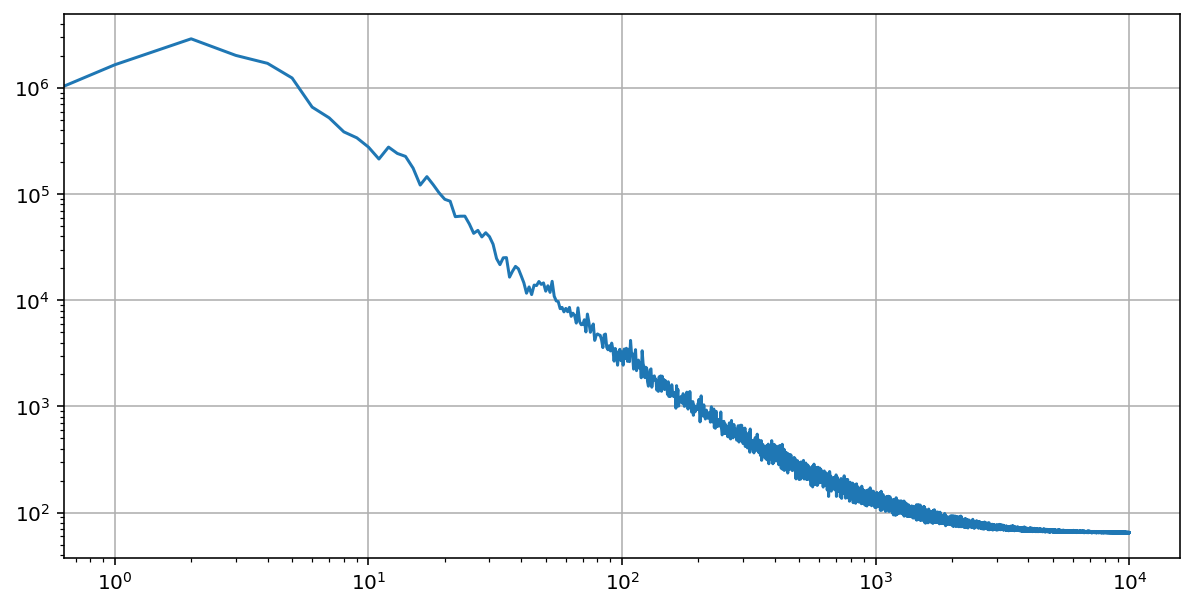

In [218]:
plt.plot(a)
plt.grid()
plt.yscale('log')
plt.xscale('log')


y_pred = predict(X_train, b)
print("Accuracy: ", get_accuracy(y_pred,y_train))

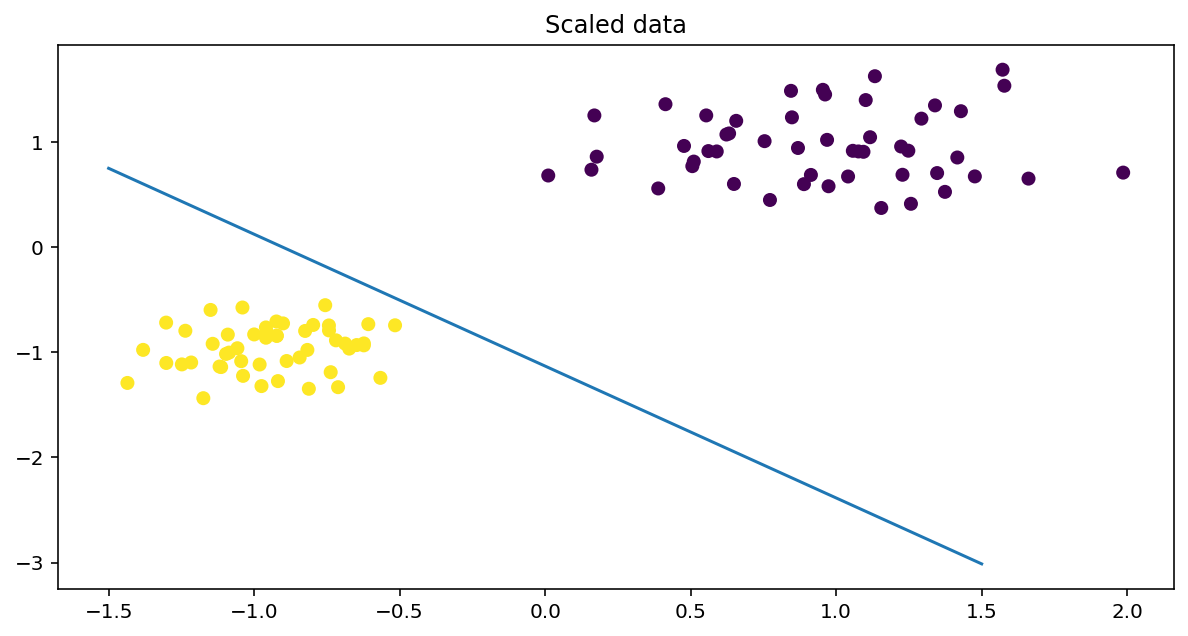

In [181]:
x_ax = np.arange(-1.5,1.6,0.1)
f = -(b[0]/b[2]) - (b[1]/b[2])*x_ax
plt.scatter(data[:,1],data[:,2], c=labels)
plt.plot(x_ax, f)
plt.title("Scaled data")
plt.show()